<a href="https://colab.research.google.com/github/ankesh86/PySparkNotebooks/blob/main/SupervisedML_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317122 sha256=273ed64ed3e7c9d29154bf4d4ccf98dc593eb2382b542498eb3676f699810f36
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('supervised_ml_classification').getOrCreate()

In [4]:
df = spark.read.csv('sample_data/bank_data.csv', inferSchema=True, header=True)
print((df.count(), len(df.columns)))

(41188, 21)


In [5]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- target_class: string (nullable = true)



In [6]:
df.groupBy('target_class').count().show()

+------------+-----+
|target_class|count|
+------------+-----+
|          no|36548|
|         yes| 4640|
+------------+-----+



## Deleting rows to reduce data size and no of columns

In [7]:
# Calculate the fraction to keep 'no' records such that 30,000 'no' records are dropped
total_no_records = 36548
records_to_keep = total_no_records - 30000
fraction_to_keep = records_to_keep / total_no_records

# Define the fractions dictionary for sampling
fractions = {'no': fraction_to_keep, 'yes': 1.0}

# Sample the DataFrame based on the fractions
sampled_df = df.sampleBy("target_class", fractions, seed=42)

# Now select the columns you want to keep
columns_to_keep = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'target_class']
new_df = sampled_df.select(columns_to_keep)

# Show the result to verify
new_df.show(5)

# Optionally, check the count of 'no' and 'yes' in the new DataFrame
new_df.groupBy('target_class').count().show()

+---+-----------+-------+-----------+-------+-------+----+------------+
|age|        job|marital|  education|default|housing|loan|target_class|
+---+-----------+-------+-----------+-------+-------+----+------------+
| 41|blue-collar|married|    unknown|unknown|     no|  no|          no|
| 35|blue-collar|married|   basic.6y|     no|    yes|  no|          no|
| 50|blue-collar|married|   basic.9y|     no|    yes| yes|          no|
| 59| technician|married|    unknown|     no|    yes|  no|          no|
| 34|   services|married|high.school|     no|     no|  no|          no|
+---+-----------+-------+-----------+-------+-------+----+------------+
only showing top 5 rows

+------------+-----+
|target_class|count|
+------------+-----+
|          no| 6573|
|         yes| 4640|
+------------+-----+



## Feature Engineering for Model

In [8]:
from pyspark.sql import functions as F
from pyspark.sql import *
new_df = new_df.withColumn("label", F.when(new_df.target_class=='no', F.lit(0)).otherwise(F.lit(1)))
new_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 4640|
|    0| 6573|
+-----+-----+



In [52]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

def cat_to_num(df):
    stages = [] # to keep the stages of the transformations

    for col in df.columns:
        stringIndexer = StringIndexer(inputCol=col, outputCol=col+"_index")
        encoder = OneHotEncoder(inputCols=[col+"_index"], outputCols=[col+"_vec"])

        stages += [stringIndexer, encoder]

    df_assembler = VectorAssembler(inputCols=['age','marital_vec','education_vec','default_vec','housing_vec','loan_vec'], outputCol="features")
    stages += [df_assembler]

    # Applying all the transformations
    from pyspark.ml import Pipeline
    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(df)
    df = model.transform(df)

    return df.select(['features', 'label'])

df_new = cat_to_num(new_df)


In [53]:
df_new.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17,[0,1,10,12,14...|    0|
|(17,[0,1,9,11,13,...|    0|
|(17,[0,1,6,11,13,...|    0|
|(17,[0,1,10,11,13...|    0|
|(17,[0,1,5,11,14,...|    0|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,1,5,11,14,...|    0|
|(17,[0,1,7,12,13,...|    0|
|(17,[0,1,9,12,14,...|    0|
|(17,[0,1,4,11,14,...|    0|
|(17,[0,2,6,11,13,...|    0|
|(17,[0,1,10,11,13...|    0|
|(17,[0,1,4,12,13,...|    0|
|(17,[0,3,8,12,13,...|    1|
|(17,[0,1,6,12,14,...|    0|
|(17,[0,1,4,12,13,...|    1|
|(17,[0,1,6,11,14,...|    1|
|(17,[0,1,4,11,13,...|    0|
|(17,[0,3,4,11,14,...|    0|
+--------------------+-----+
only showing top 20 rows



## Split the Data into Train and Test Datasets

In [54]:
train, test = df_new.randomSplit([0.75,0.25])
print(f"Size of train Dataset : {train.count()}")
print(f"Size of test Dataset : {test.count()}")

Size of train Dataset : 8324
Size of test Dataset : 2889


## Build and Train the Logistic Regression model

In [55]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()
lr_model = lr.fit(train)
print(lr_model.coefficients)

[0.021032026225427766,-0.5123716466740033,-0.052474288772691585,-0.5941963027830527,-0.2111231110050117,-0.4628030123024023,-0.7439711954462664,-0.37438334892247194,-0.37616031450241844,-0.5160105979425151,-0.09694078718101883,11.92349137196805,10.9382065726764,0.04632302252053307,0.01652863558574699,0.08180231313142396,0.031106253222249792]


## Evaluate Performance on Training Data

In [56]:
lr_summary = lr_model.summary
print(f"{lr_summary.accuracy}")
print(f"{lr_summary.areaUnderROC}")
print(f"{lr_summary.weightedRecall}")
print(f"{lr_summary.weightedPrecision}")

0.6123258049014897
0.631797537669213
0.6123258049014897
0.5987321781411319


In [57]:
lr_summary.precisionByThreshold.show()

+------------------+------------------+
|         threshold|         precision|
+------------------+------------------+
|0.7368603889114904|               1.0|
|0.7238017503470731|               1.0|
|0.7110116721612687|0.6666666666666666|
|0.7028790875783076|             0.625|
|0.6915577605368972|               0.7|
|0.6804597834440027|0.7142857142857143|
|0.6759263659093047|0.7777777777777778|
|0.6733584321902079|              0.75|
|0.6686868692903016|0.6818181818181818|
|0.6666786911152485|0.6666666666666666|
|0.6640109174035398|0.7037037037037037|
|0.6619547212938801|0.7333333333333333|
|0.6597209873906598|              0.75|
| 0.659203697912911|0.7222222222222222|
|0.6577511877945909|0.7435897435897436|
|0.6545626193095236|0.7142857142857143|
|0.6524199440251706|0.7333333333333333|
|0.6497917263280151|0.7446808510638298|
|0.6488946039843189|0.7692307692307693|
|0.6470538468567755|0.7636363636363637|
+------------------+------------------+
only showing top 20 rows



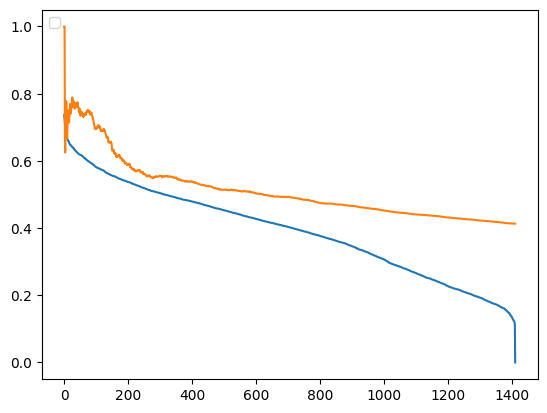

In [58]:
import matplotlib.pyplot as plt

# Assuming lr_summary is a BinaryClassificationMetrics object

# Get the precision by threshold DataFrame
precision_by_threshold = lr_summary.precisionByThreshold

# Collect the DataFrame to the driver
precision_by_threshold_list = precision_by_threshold.collect()

# Extract threshold and precision values
thresholds = [row['threshold'] for row in precision_by_threshold_list]
precisions = [row['precision'] for row in precision_by_threshold_list]

# Now use matplotlib to plot the precision against threshold
plt.plot(precision_by_threshold_list)
plt.legend(loc='upper left')
plt.show()


## **Different Graphs**
* From the ROC Curve, a curve close to the top-left corner indicates a better performance.
* From the Precision-Recall Curve, a higher area under the curve (AUC) indicates that the classifier is returning more true positives and fewer false negatives.
* The Threshold vs. Metrics Plot will show you how the balance between precision and recall changes as you adjust the threshold. The optimal point often maximizes the F-Measure, which balances precision and recall.
* The Confusion Matrix is a direct way to see the actual versus predicted counts of the classes.
* For a Calibration Curve, if the plot significantly deviates from the diagonal, it indicates that the predicted probabilities are not representative of the actual outcomes.

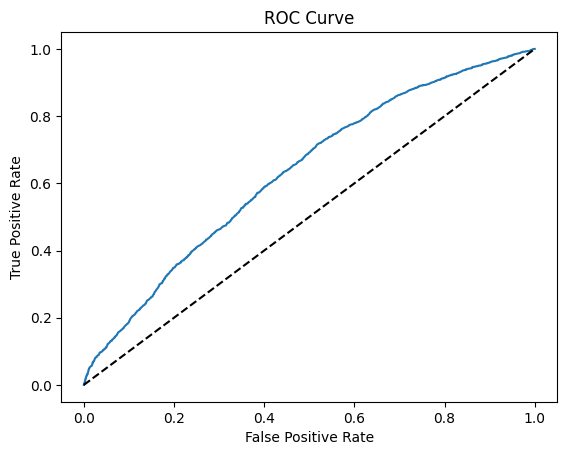

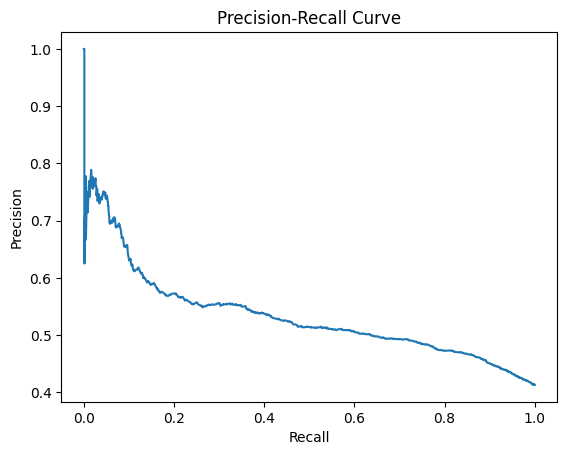

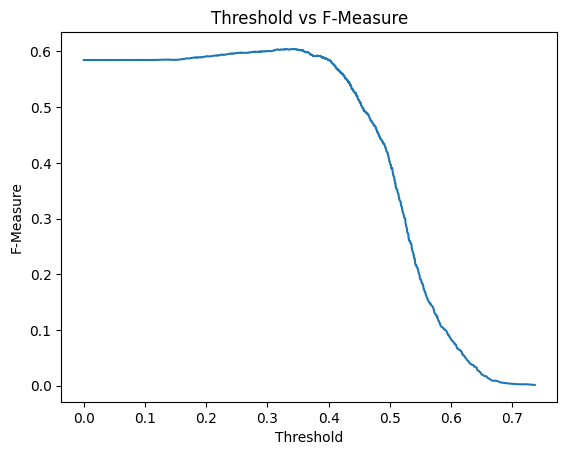

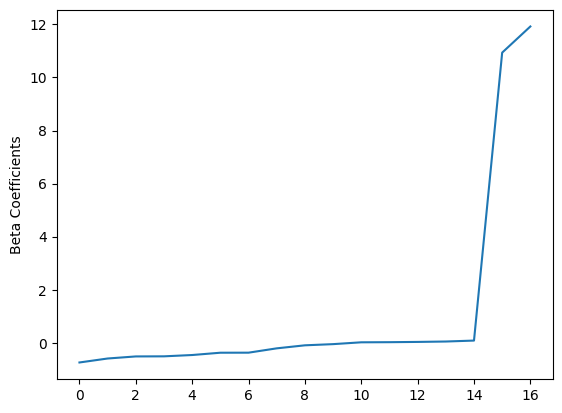

In [59]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt

# Assuming predictions is a DataFrame with the logistic regression model's predictions
# It needs to have a column with the label and a column with the prediction

# ROC Curve
roc = lr_summary.roc.toPandas()
plt.figure()
plt.plot(roc['FPR'], roc['TPR'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Precision-Recall Curve
pr = lr_summary.pr.toPandas()
plt.figure()
plt.plot(pr['recall'], pr['precision'])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Threshold vs. Metrics Plot
f_measure = lr_summary.fMeasureByThreshold.toPandas()
plt.figure()
plt.plot(f_measure['threshold'], f_measure['F-Measure'])
plt.xlabel('Threshold')
plt.ylabel('F-Measure')
plt.title('Threshold vs F-Measure')
plt.show()

import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lr_model.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()
plt.show()


In [60]:
lr_summary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|5.817335660267597E-4|
|                 0.0|0.001163467132053...|
|4.093327875562832...|0.001163467132053...|
|6.139991813344249E-4|0.001454333915066...|
|6.139991813344249E-4|0.002036067481093659|
|8.186655751125665E-4|0.002908667830133...|
|8.186655751125665E-4|0.004072134962187318|
|0.001023331968890708|0.004363001745200698|
|0.001432664756446...|0.004363001745200698|
|0.001637331150225133|0.004653868528214078|
|0.001637331150225133|0.005526468877254218|
|0.001637331150225133|0.006399069226294357|
|0.001637331150225133|0.006980802792321117|
|0.002046663937781416|0.007562536358347...|
|0.002046663937781416|0.008435136707388016|
|0.002455996725337...|0.008726003490401396|
|0.002455996725337...|0.009598603839441536|
|0.002455996725337...|0.010180337405468295|
|0.002455996725337...|0.01163467

In [61]:
lr_summary.recallByThreshold.show()

+------------------+--------------------+
|         threshold|              recall|
+------------------+--------------------+
|0.7368603889114904|5.817335660267597E-4|
|0.7238017503470731|0.001163467132053...|
|0.7110116721612687|0.001163467132053...|
|0.7028790875783076|0.001454333915066...|
|0.6915577605368972|0.002036067481093659|
|0.6804597834440027|0.002908667830133...|
|0.6759263659093047|0.004072134962187318|
|0.6733584321902079|0.004363001745200698|
|0.6686868692903016|0.004363001745200698|
|0.6666786911152485|0.004653868528214078|
|0.6640109174035398|0.005526468877254218|
|0.6619547212938801|0.006399069226294357|
|0.6597209873906598|0.006980802792321117|
| 0.659203697912911|0.007562536358347...|
|0.6577511877945909|0.008435136707388016|
|0.6545626193095236|0.008726003490401396|
|0.6524199440251706|0.009598603839441536|
|0.6497917263280151|0.010180337405468295|
|0.6488946039843189|0.011634671320535195|
|0.6470538468567755|0.012216404886561954|
+------------------+--------------

In [62]:
lr_summary.pr.show()

+--------------------+------------------+
|              recall|         precision|
+--------------------+------------------+
|                 0.0|               1.0|
|5.817335660267597E-4|               1.0|
|0.001163467132053...|               1.0|
|0.001163467132053...|0.6666666666666666|
|0.001454333915066...|             0.625|
|0.002036067481093659|               0.7|
|0.002908667830133...|0.7142857142857143|
|0.004072134962187318|0.7777777777777778|
|0.004363001745200698|              0.75|
|0.004363001745200698|0.6818181818181818|
|0.004653868528214078|0.6666666666666666|
|0.005526468877254218|0.7037037037037037|
|0.006399069226294357|0.7333333333333333|
|0.006980802792321117|              0.75|
|0.007562536358347...|0.7222222222222222|
|0.008435136707388016|0.7435897435897436|
|0.008726003490401396|0.7142857142857143|
|0.009598603839441536|0.7333333333333333|
|0.010180337405468295|0.7446808510638298|
|0.011634671320535195|0.7692307692307693|
+--------------------+------------

## Evaluate Performance on test data

In [63]:
model_predictions = lr_model.transform(test)
model_predictions.columns

['features', 'label', 'rawPrediction', 'probability', 'prediction']

In [64]:
model_predictions.select(['label', 'probability', 'prediction']).show(10, False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.5943016250195454,0.4056983749804546] |0.0       |
|1    |[0.5943016250195454,0.4056983749804546] |0.0       |
|0    |[0.5790027518929994,0.42099724810700057]|0.0       |
|1    |[0.5583708460012915,0.4416291539987085] |0.0       |
|1    |[0.5323031173912324,0.46769688260876763]|0.0       |
|1    |[0.6039397000010821,0.3960602999989179] |0.0       |
|0    |[0.5988980766649199,0.4011019233350801] |0.0       |
|1    |[0.5988980766649199,0.4011019233350801] |0.0       |
|1    |[0.5988980766649199,0.4011019233350801] |0.0       |
|1    |[0.5938354369641148,0.4061645630358852] |0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [65]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [66]:
# RMSE value of the model on test data
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
lr_auroc = lr_evaluator.evaluate(model_predictions)
print(f'The auc value of Logistic Regression Model is {lr_auroc}')


# RMSE value of the model on test data
lr_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
lr_aupr = lr_evaluator.evaluate(model_predictions)
print(f'The aupr value of Logistic Regression Model is {lr_aupr}')

The auc value of Logistic Regression Model is 0.6080874890397061
The aupr value of Logistic Regression Model is 0.506776100664611


In [67]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()


In [68]:
#Recall
float(true_pos)/(actual_pos)

0.31114808652246256

In [69]:
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()
#Precision
float(true_pos)/(pred_pos)

0.53125

## **Decision Tree Classifier**

In [70]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_model = dt.fit(train)

In [71]:
model_predictions = dt_model.transform(test)

In [72]:
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.5434402332361516,0.4565597667638484] |0.0       |
|1    |[0.5434402332361516,0.4565597667638484] |0.0       |
|0    |[0.5434402332361516,0.4565597667638484] |0.0       |
|1    |[0.5434402332361516,0.4565597667638484] |0.0       |
|1    |[0.5434402332361516,0.4565597667638484] |0.0       |
|1    |[0.46511627906976744,0.5348837209302325]|1.0       |
|0    |[0.46511627906976744,0.5348837209302325]|1.0       |
|1    |[0.46511627906976744,0.5348837209302325]|1.0       |
|1    |[0.46511627906976744,0.5348837209302325]|1.0       |
|1    |[0.5434402332361516,0.4565597667638484] |0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [73]:
# RMSE value of the model on test data
dt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
dt_auroc = dt_evaluator.evaluate(model_predictions)
print(f'The auc value of Decision Tree Classifier Model is {dt_auroc}')


# RMSE value of the model on test data
dt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
dt_aupr = dt_evaluator.evaluate(model_predictions)
print(f'The aupr value of Logistic Regression Model is {dt_aupr}')

The auc value of Decision Tree Classifier Model is 0.4538077221623318
The aupr value of Logistic Regression Model is 0.38365807505549065


In [74]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

In [75]:
#Recall
float(true_pos)/(actual_pos)


0.2762063227953411

In [76]:
#Precision on test Data
float(true_pos)/(pred_pos)

0.6384615384615384

## **Support Vector Machines**

## Build and train SVM model

In [77]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=50,maxDepth=30)
rf_model = rf.fit(train)

In [78]:
model_predictions = rf_model.transform(test)
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.5439921506650566,0.45600784933494337]|0.0       |
|1    |[0.5439921506650566,0.45600784933494337]|0.0       |
|0    |[0.5550820240439027,0.4449179759560973] |0.0       |
|1    |[0.607476385343094,0.39252361465690594] |0.0       |
|1    |[0.5186328140209097,0.48136718597909045]|0.0       |
|1    |[0.41423291085687347,0.5857670891431266]|1.0       |
|0    |[0.4621665851188625,0.5378334148811376] |1.0       |
|1    |[0.4621665851188625,0.5378334148811376] |1.0       |
|1    |[0.4621665851188625,0.5378334148811376] |1.0       |
|1    |[0.489696243858727,0.510303756141273]   |1.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



## Evaluate performance on test data

In [79]:
rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
rf_auroc = rf_evaluator.evaluate(model_predictions)
print(f'The auc value of RandomForestClassifier Model is {rf_auroc}')

rf_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
rf_aupr = rf_evaluator.evaluate(model_predictions)
print(f'The aupr value of RandomForestClassifier Model is {rf_aupr}')


The auc value of RandomForestClassifier Model is 0.6369085016377571
The aupr value of RandomForestClassifier Model is 0.5634216901785816


In [80]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()


In [81]:
#Recall
float(true_pos)/(actual_pos)

0.26955074875207985

In [82]:
#Precision on test Data
float(true_pos)/(pred_pos)


0.5977859778597786

# **Naive bayes Classifier**

## Build and train NaiveBayes model

In [83]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes()
nb_model = nb.fit(train)
model_predictions = nb_model.transform(test)
model_predictions.columns

['features', 'label', 'rawPrediction', 'probability', 'prediction']

In [84]:
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.5089596817190444,0.4910403182809557] |0.0       |
|1    |[0.5089596817190444,0.4910403182809557] |0.0       |
|0    |[0.5066709405562219,0.49332905944377803]|0.0       |
|1    |[0.5036188672558028,0.4963811327441971] |0.0       |
|1    |[0.4998034229947329,0.500196577005267]  |1.0       |
|1    |[0.5203653137912378,0.4796346862087621] |0.0       |
|0    |[0.519603431502048,0.48039656849795215] |0.0       |
|1    |[0.519603431502048,0.48039656849795215] |0.0       |
|1    |[0.519603431502048,0.48039656849795215] |0.0       |
|1    |[0.5188414580290095,0.48115854197099056]|0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [85]:
nb_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
nb_auroc = nb_evaluator.evaluate(model_predictions)
print(f'The auc value of NB Classifier  is {nb_auroc}')

nb_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
nb_aupr =nb_evaluator.evaluate(model_predictions)
print(f'The aupr value of NB Classifier Model is {nb_aupr}')

The auc value of NB Classifier  is 0.5523554400046555
The aupr value of NB Classifier Model is 0.4589277599002511


In [86]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()

In [87]:
float(true_pos)/(actual_pos)

0.24292845257903495

In [88]:
float(true_pos)/(pred_pos)

0.4882943143812709

## **Gradient Boosted Tree Classifier**

In [89]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier()
gbt_model = gbt.fit(train)
model_predictions = gbt_model.transform(test)
model_predictions.select(['label','probability','prediction']).show(10,False)

+-----+----------------------------------------+----------+
|label|probability                             |prediction|
+-----+----------------------------------------+----------+
|0    |[0.5838293236236349,0.41617067637636507]|0.0       |
|1    |[0.5838293236236349,0.41617067637636507]|0.0       |
|0    |[0.5838293236236349,0.41617067637636507]|0.0       |
|1    |[0.5838293236236349,0.41617067637636507]|0.0       |
|1    |[0.6270367531539184,0.3729632468460816] |0.0       |
|1    |[0.45259688270889376,0.5474031172911062]|1.0       |
|0    |[0.4513846109023134,0.5486153890976866] |1.0       |
|1    |[0.4513846109023134,0.5486153890976866] |1.0       |
|1    |[0.4513846109023134,0.5486153890976866] |1.0       |
|1    |[0.5437036262841555,0.4562963737158445] |0.0       |
+-----+----------------------------------------+----------+
only showing top 10 rows



In [90]:
gbt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
gbt_auroc = gbt_evaluator.evaluate(model_predictions)
print(f'The auc value of GradientBoostedTreesClassifier  is {gbt_auroc}')

gbt_evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
gbt_aupr = gbt_evaluator.evaluate(model_predictions)
print(f'The aupr value of GradientBoostedTreesClassifier Model is {gbt_aupr}')


The auc value of GradientBoostedTreesClassifier  is 0.6466647663891543
The aupr value of GradientBoostedTreesClassifier Model is 0.5710262636410522


In [91]:
true_pos=model_predictions.filter(model_predictions['label']==1).filter(model_predictions['prediction']==1).count()
actual_pos=model_predictions.filter(model_predictions['label']==1).count()
pred_pos=model_predictions.filter(model_predictions['prediction']==1).count()


In [92]:
float(true_pos)/(actual_pos)


0.2670549084858569

In [93]:

float(true_pos)/(pred_pos)

0.6149425287356322